# Point estimators

* A point estimator is an algorithm or function that given a set of data points $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ outputs a real value.
* A good point estimator tries to approximate some characteristic of the data set and its value converges to the true value in the process $n\to \infty$

## I. Theoretical formalisation
* Let $\mathcal{D}_{\alpha_1,\alpha_2,\ldots,\alpha_k}$ be a parametrised distribution that generates samples $\boldsymbol{x}_i$. 
* Then we might want to infer what are the values of $\alpha_1,\alpha_2,\ldots,\alpha_k$ form obsereved data.
* We can use point estimator $f$ for estimating the value of $\alpha_i$.
* As data generation is random process point estimator outcomes $y=f(\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n)$ are also random.

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from plotnine import *

# Local imports
from convenience import *

In [2]:
def data_sampler(n:int, mu:float=0,  sigma: float=1) -> Series:
    """
    Data generator that generates n values form the normal distribution N(mu, sigma)
    """
    
    return Series(np.random.normal(loc=mu, scale=sigma, size = n))

In [3]:
data_sampler(10)

0   -0.597224
1    0.634656
2    0.759744
3    0.459956
4   -0.198776
5   -0.719145
6    0.192727
7    0.038994
8   -1.754501
9    0.942411
dtype: float64

For this particular data distribution there are parameters we can estimate $\mu$ and $\sigma$. 
Let us consider three point estimators for the $\mu$ value

In [4]:
def f0(x):
    return 0

def f1(x):
    return np.mean(x)

def f2(x):
    return np.random.uniform(-1,1,1)

Then the corresponding distributions of the point estimator values can be empirically measured.

In [41]:
k = 1000
sample_size = [1, 10, 50, 100, 250, 500, 750, 1000] 

result = (combine_categories({'sample_size': sample_size, 'method': ['f0', 'f1', 'f2'], 'experiment': list(range(k))})
         .assign(value = np.nan)
         .set_index(['sample_size', 'method', 'experiment'])
         .sort_index())
head(result)

value
sample_size method experiment       
1           f0     0             NaN
                   1             NaN
                   2             NaN
                   3             NaN
                   4             NaN

In [42]:
from tqdm.notebook import trange

for size in sample_size:
    for experiment in trange(k, desc = 'Size: {:_>4}'.format(size)):
        data = data_sampler(size)
        result.loc[(size, 'f0', experiment), 'value'] = f0(data)
        result.loc[(size, 'f1', experiment), 'value'] = f1(data)
        result.loc[(size, 'f2', experiment), 'value'] = f2(data)
tail(result)

value
sample_size method experiment          
1000        f2     995        -0.305244
                   996        -0.596388
                   997         0.380658
                   998         0.713209
                   999        -0.454165

Let us explore the resulting distributions

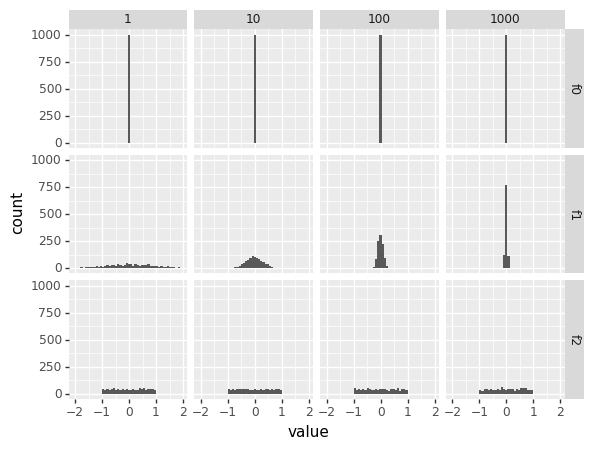

<ggplot: (-9223372029837087509)>

In [43]:
# Drop values outside [-2, 2] for clarity
p = ggplot(result
           .loc[[1, 10, 100, 1000]]
           .reset_index()
           .pipe(lambda df: df.loc[abs(df['value'])<= 2]))
p = p + geom_histogram(aes(x='value'), bins=50)
p = p + facet_grid(['method', 'sample_size']) 
p

## II. Bias and variance 

* A point estimator does not have to provide the correct answer.
* A point estimator is unbiased if its expected value coincides with the true parameter value.
* A statistical variance of the point estimator shows how much a point estimate fluctuates.
* A point estimator is reasonable if its variance decreases as $n\to\infty$.
* A point estimator is asymptotocally consistent if the estimator converges in probabilty to the true value.
* A biased estimator can be also asymptotocally consistent and more effective.

In [44]:
sdf = (result
       .groupby(['method', 'sample_size'])
       .aggregate(
           mean = ('value', np.mean), 
           std  = ('value', np.std),
           q05  = ('value', lambda x: np.quantile(x, q=0.05)),
           q50  = ('value', lambda x: np.quantile(x, q=0.50)),
           q95  = ('value', lambda x: np.quantile(x, q=0.95)))
      )
head(sdf)

mean  std  q05  q50  q95
method sample_size                          
f0     1             0.0  0.0  0.0  0.0  0.0
       10            0.0  0.0  0.0  0.0  0.0
       50            0.0  0.0  0.0  0.0  0.0
       100           0.0  0.0  0.0  0.0  0.0
       250           0.0  0.0  0.0  0.0  0.0

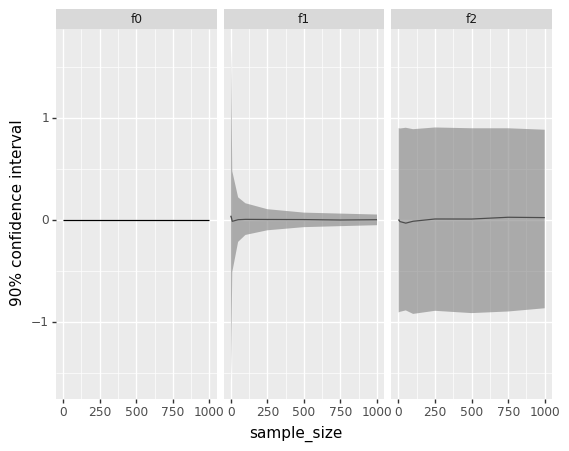

<ggplot: (-9223372029837607378)>

In [45]:
p = ggplot(sdf.reset_index())
p = p + geom_line(aes(x = 'sample_size', y = 'q50'))
p = p + geom_ribbon(aes(x = 'sample_size', ymin = 'q05', ymax = 'q95'), fill='grey', alpha=0.6)
p = p + facet_wrap('method')
p + scale_y_continuous(name = '90% confidence interval')

## III. Moment matching and confidence intervals

* Reasonable point estimators have a distribution that is close to a normal distribution.
* Normal distribution is fixed by mean and variance.
* If we can estimate mean and variance of the point estimator we can fix corresponding normal approximation. 
* It is straightforward to find confidence intervals (typical regions) for a normal distribution. 

### Mean and variance of  the second point estimator

The second point estimator in our examples is actually a reasonable estimator and thus we can define normal appoximation.

In [68]:
df = result.reset_index('sample_size').loc['f1']
display(head(df))

sdf = (df
       .groupby('sample_size')
       .aggregate(mean = ('value', np.mean), std  = ('value', np.std)))
sdf

,sample_size,value
experiment,,
0,1,2.151232
1,1,-0.647037
2,1,-0.541804
3,1,-0.318292
4,1,0.044113


,mean,std
sample_size,,
1,0.043651,1.020518
10,-0.014527,0.312893
50,0.000284,0.138637
100,0.003160,0.098438
250,0.001745,0.062416
500,0.000321,0.044332
750,-0.001678,0.037250
1000,-0.000353,0.032252


### Theoretical histogram approximation

* Let us now use moment matching to compute expected histogram values for various dataset sizes. 
* We use cumulative probability density function for the normal distribution from `scipy.stats` for that.



,x,sample_size,prob
0,-4.00,1,0.000039
1,-3.75,1,0.000101
2,-3.50,1,0.000242
3,-3.25,1,0.000547
4,-3.00,1,0.001167


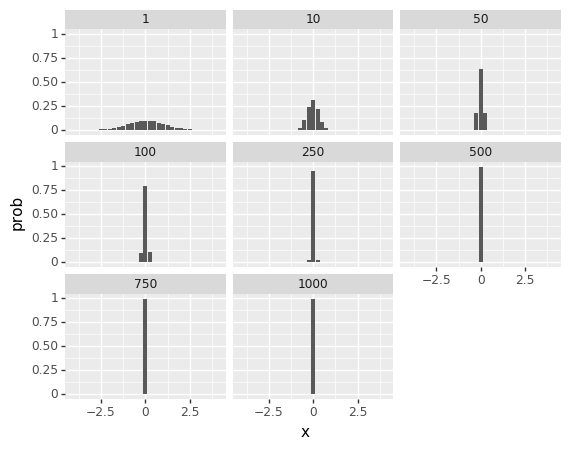

<ggplot: (7018566874)>

In [207]:
from scipy.stats import norm

tdf = pd.concat([DataFrame({'x': [0.25 * x  for x  in range(-16,17)]})
                   .assign(sample_size=size)
                   .assign(
                       prob =  lambda df: 
                           norm.cdf(df['x'] + 0.125, loc=sdf.loc[size, 'mean'], scale=sdf.loc[size, 'std']) -
                           norm.cdf(df['x'] - 0.125, loc=sdf.loc[size, 'mean'], scale=sdf.loc[size, 'std'])
                    ) for size in sample_size])

display(head(tdf))

p = ggplot(tdf)
p = p + geom_col(aes(x = 'x', y = 'prob'))
p = p + facet_wrap('sample_size')
p

### Comparison with real values

* As there are 1000 samples we must rescale the theoretical probability distribution to match histogram counts. 

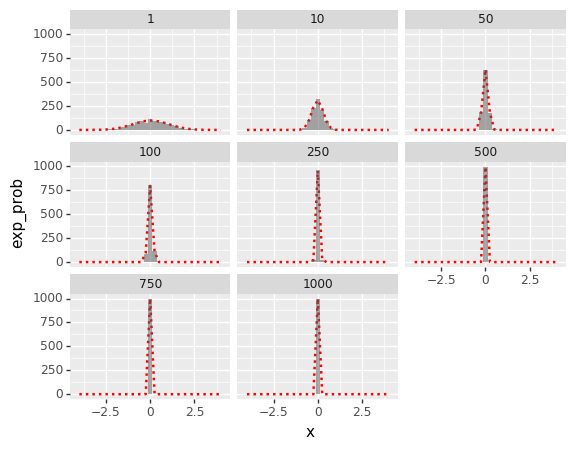

<ggplot: (7017963349)>

In [208]:
p = ggplot(tdf.assign(exp_prob = lambda df: df['prob']*1000))
p = p + geom_line(aes(x = 'x', y = 'exp_prob'), color='red', size=1, linetype=':')
p = p + geom_histogram(aes(x = 'value'), data=df, center=0, binwidth=0.25, alpha=0.5)
p = p + facet_wrap('sample_size')
p